# Exploratory Data Analysis: German Used Car Dataset

### Business Context
This project performs an in-depth Exploratory Data Analysis (EDA) on a dataset of used car listings from Germany. The goal is to act as a data analyst for a potential used car dealership, uncovering key insights that could inform purchasing, pricing, and sales strategy.

### Key Questions
Based on my initial project plan, I will be investigating the following questions:
1. What is the average price trend for top German brands over the last 10 years?
2. How does mileage impact the price of a 5-year-old Volkswagen Golf?
3. Is there a specific color that holds its value better than others?

## Importing Libraries

In [52]:
import pandas as pd
import numpy as np
from ydata_profiling import ProfileReport
import seaborn as sns
import matplotlib.pyplot as plt

## Loading Dataset

In [53]:
df_org = pd.read_csv('data.csv')
df = df_org.copy()
df = df.iloc[:, 1:]
df.head()

,brand,model,color,registration_date,year,price_in_euro,power_kw,power_ps,transmission_type,fuel_type,fuel_consumption_l_100km,fuel_consumption_g_km,mileage_in_km,offer_description
0,alfa-romeo,Alfa Romeo GTV,red,10/1995,1995,1300,148,201,Manual,Petrol,"10,9 l/100 km",260 g/km,160500.0,2.0 V6 TB
1,alfa-romeo,Alfa Romeo 164,black,02/1995,1995,24900,191,260,Manual,Petrol,NaN,- (g/km),190000.0,"Q4 Allrad, 3.2L GTA"
2,alfa-romeo,Alfa Romeo Spider,black,02/1995,1995,5900,110,150,Unknown,Petrol,NaN,- (g/km),129000.0,ALFA ROME 916
3,alfa-romeo,Alfa Romeo Spider,black,07/1995,1995,4900,110,150,Manual,Petrol,"9,5 l/100 km",225 g/km,189500.0,2.0 16V Twin Spark L
4,alfa-romeo,Alfa Romeo 164,red,11/1996,1996,17950,132,179,Manual,Petrol,"7,2 l/100 km",- (g/km),96127.0,"3.0i Super V6, absoluter Topzustand !"


## 1) Data Understanding

### Export Report File using ydata_profiling package

In [54]:
# profile = ProfileReport(df, title="Profiling Report")
# profile.to_file("used_car_report.html")

### Data Preparing
#### Initial Data Inspection
The first step is to get a high-level overview of the dataset. I'll use `.info()` to understand the data types of each column and identify any immediate issues, like numbers being stored as text.

In [55]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 251079 entries, 0 to 251078
Data columns (total 14 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   brand                     251079 non-null  object 
 1   model                     251079 non-null  object 
 2   color                     250913 non-null  object 
 3   registration_date         251075 non-null  object 
 4   year                      251079 non-null  object 
 5   price_in_euro             251079 non-null  object 
 6   power_kw                  250945 non-null  object 
 7   power_ps                  250950 non-null  object 
 8   transmission_type         251079 non-null  object 
 9   fuel_type                 251079 non-null  object 
 10  fuel_consumption_l_100km  224206 non-null  object 
 11  fuel_consumption_g_km     251079 non-null  object 
 12  mileage_in_km             250927 non-null  float64
 13  offer_description         251078 non-null  o

#### Assessing Missing Data
Next, I'll check for missing values. This is crucial for data quality. Any columns with a high percentage of missing data might need to be dropped or imputed carefully.

In [56]:
df.isnull().sum()

brand                           0
model                           0
color                         166
registration_date               4
year                            0
price_in_euro                   0
power_kw                      134
power_ps                      129
transmission_type               0
fuel_type                       0
fuel_consumption_l_100km    26873
fuel_consumption_g_km           0
mileage_in_km                 152
offer_description               1
dtype: int64

The fuel_consumption_l_100km column has a significant number of missing values (over 26,000), which confirms it needs special attention.

#### Fixing columns in which contains different types of units

In [57]:
# Convert comma decimal separator to a period for later conversion to float
df.fuel_consumption_l_100km = df.fuel_consumption_l_100km.str.replace(',','.')

# Use string methods with boolean masks to identify the different unit types
is_l_km = df.fuel_consumption_l_100km.str.contains('l/100 km', na=False)
is_km = df.fuel_consumption_l_100km.str.contains('km', na=False) & ~df.fuel_consumption_l_100km.str.contains('/', na=False)
is_kwh = df.fuel_consumption_l_100km.str.contains('kWh/100 km', na=False)
is_kg = df.fuel_consumption_l_100km.str.contains('kg/100 km', na=False)

df['fuel_consumption_l_100_km'] = df.loc[is_l_km, 'fuel_consumption_l_100km']
df['fuel_consumption_km'] = df.loc[is_km, 'fuel_consumption_l_100km']
df['fuel_consumption_kWh_100km'] = df.loc[is_kwh, 'fuel_consumption_l_100km']
df['fuel_consumption_kg_100km'] = df.loc[is_kg, 'fuel_consumption_l_100km']

df['fuel_consumption_l_100_km'] = df['fuel_consumption_l_100_km'].str.replace('- (l/100 km)','').str.replace(' l/100 km','').replace('', np.nan)
df['fuel_consumption_km'] = df['fuel_consumption_km'].str.replace(' km (Ort)','')
df['fuel_consumption_kWh_100km'] = df['fuel_consumption_kWh_100km'].str.replace(' kWh/100 km','')
df['fuel_consumption_kg_100km'] = df['fuel_consumption_kg_100km'].str.replace(' kg/100 km','')

#### Drop Columns

In [58]:
df = df.drop(columns=['power_ps', 'fuel_consumption_l_100km', 'fuel_consumption_g_km', 'offer_description'])

#### Removing wrong entry data in columns

In [59]:
year_count = df.year.value_counts()
mask = df.year.map(year_count) < 170
df_cond = df[mask]
df_cond.year.value_counts()

year
Petrol       51
Hybrid       24
Manual       20
Diesel       20
Automatic    14
             ..
39.900 km     1
18.990 km     1
05/2015       1
05/2016       1
CNG           1
Name: count, Length: 62, dtype: int64

In [60]:
mask = df.year.map(year_count) >= 170
df = df[mask]
df.year.value_counts()[-3:]

year
1997    343
1996    227
1995    170
Name: count, dtype: int64

In [61]:
registration_count = df.registration_date.value_counts()
mask = df.registration_date.map(registration_count) < 8
df_cond = df[mask]
df_cond['registration_date'].value_counts()

registration_date
10/1995    3
07/2023    3
11/2023    1
Name: count, dtype: int64

In [62]:
mask = df.registration_date.map(registration_count) >= 8
df = df[mask]
df['registration_date'].value_counts()[-3:]

registration_date
12/1995    9
08/1996    8
09/1995    8
Name: count, dtype: int64

#### Replacing Null Values with appropriate values

In [63]:
df.color = df.color.fillna(df.color.mode()[0])
df.fuel_type = df.fuel_type.replace('Other', 'Unknown')
df['fuel_consumption_l_100_km'] = df['fuel_consumption_l_100_km'].fillna(0)
df['fuel_consumption_km'] = df['fuel_consumption_km'].fillna(0)
df['fuel_consumption_kWh_100km'] = df['fuel_consumption_kWh_100km'].fillna(0)
df['fuel_consumption_kg_100km'] = df['fuel_consumption_kg_100km'].fillna(0)
df.mileage_in_km = df.mileage_in_km.fillna(df.mileage_in_km.mean())

In [64]:
df = df.dropna(subset=['registration_date', 'power_kw'])

#### Converting columns to appropriate Data Types

In [65]:
df.year = df.year.astype('int')
df.price_in_euro = df.price_in_euro.astype('int')
df.power_kw = df.power_kw.astype('int')
df['fuel_consumption_l_100_km'] = df['fuel_consumption_l_100_km'].astype('float')
df['fuel_consumption_km'] = df['fuel_consumption_km'].astype('float')
df['fuel_consumption_kWh_100km'] = df['fuel_consumption_kWh_100km'].astype('float')
df['fuel_consumption_kg_100km'] = df['fuel_consumption_kg_100km'].astype('float')

In [66]:
clean_df = df
clean_df.to_csv('clean_used_cars_dataset.csv', index=False)

## 2) Data Analyzing & Visualization

### 2.1) Univariate Analysis: Understanding Individual Features
Now that the data is clean, I'll start by analyzing individual variables to understand their distributions.

##### Category Columns

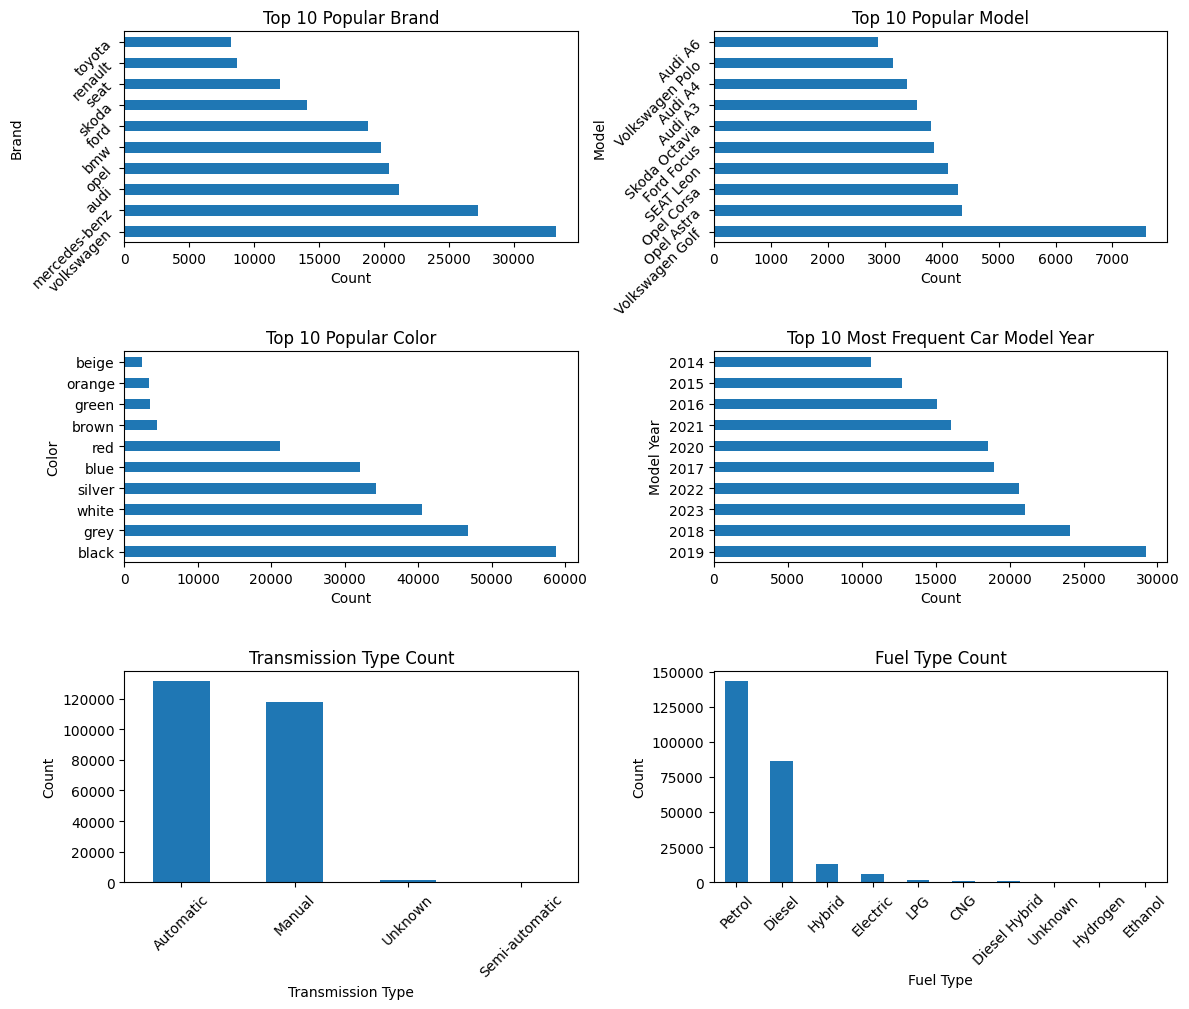

In [67]:
fig, axes = plt.subplots(3,2, figsize=(12,12))

brand_count = clean_df.brand.value_counts()
brand_count[:10].plot(kind='barh', ax=axes[0,0], title='Top 10 Popular Brand', xlabel='Count', ylabel='Brand', rot=45)

model_count = clean_df.model.value_counts()
model_count[:10].plot(kind='barh', ax=axes[0,1], title='Top 10 Popular Model', xlabel='Count', ylabel='Model', rot=45)

color_count = clean_df.color.value_counts()
color_count[:10].plot(kind='barh', ax=axes[1,0], title='Top 10 Popular Color', xlabel='Count', ylabel='Color')

year_count = clean_df.year.value_counts()
year_count[:10].plot(kind='barh', ax=axes[1,1], title='Top 10 Most Frequent Car Model Year', xlabel='Count', ylabel='Model Year')

transmission_type_count = clean_df.transmission_type.value_counts()
transmission_type_count[:10].plot(kind='bar', ax=axes[2,0], title='Transmission Type Count', xlabel='Transmission Type', ylabel='Count', rot=45)

fuel_type_count = clean_df.fuel_type.value_counts()
fuel_type_count[:10].plot(kind='bar', ax=axes[2,1], title='Fuel Type Count', xlabel='Fuel Type', ylabel='Count', rot=45)

plt.tight_layout(rect=[0, 0.1, 1, 0.95])

#### Which car brands are most common in the dataset?
**Insight:** As expected for a German dataset, domestic brands like **Volkswagen, Mercedes-Benz, and Audi** dominate the listings. This confirms the dataset is representative of the German market.

##### Numerical Columns

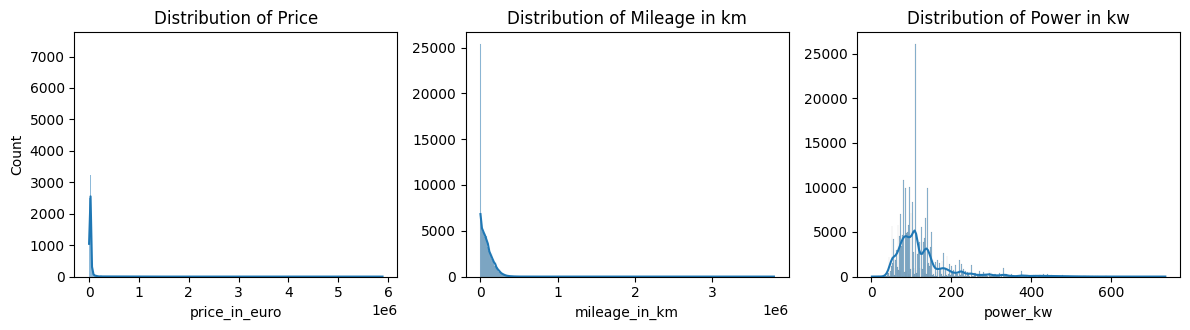

In [68]:
fig, axes = plt.subplots(1,3, figsize=(12,4))

sns.histplot(clean_df, x='price_in_euro', kde=True, ax=axes[0])
axes[0].set_title('Distribution of Price')

sns.histplot(clean_df, x='mileage_in_km', kde=True, ax=axes[1])
axes[1].set_title('Distribution of Mileage in km')
axes[1].set_ylabel('')

sns.histplot(clean_df, x='power_kw', kde=True, ax=axes[2])
axes[2].set_title('Distribution of Power in kw')
axes[2].set_ylabel('')

plt.tight_layout(rect=[0, 0.1, 1, 0.95])
plt.show()

Since the distributions are right skewed, we should transform using log transformation.

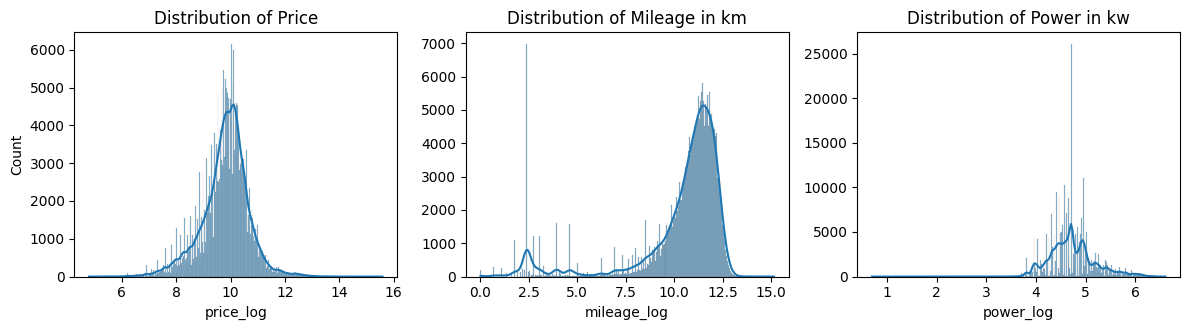

In [69]:
clean_df['price_log'] = np.log1p(clean_df['price_in_euro'])
clean_df['mileage_log'] = np.log1p(clean_df['mileage_in_km'])
clean_df['power_log'] = np.log1p(clean_df['power_kw'])

fig, axes = plt.subplots(1,3, figsize=(12,4))

sns.histplot(clean_df, x='price_log', kde=True, ax=axes[0])
axes[0].set_title('Distribution of Price')

sns.histplot(clean_df, x='mileage_log', kde=True, ax=axes[1])
axes[1].set_title('Distribution of Mileage in km')
axes[1].set_ylabel('')

sns.histplot(clean_df, x='power_log', kde=True, ax=axes[2])
axes[2].set_title('Distribution of Power in kw')
axes[2].set_ylabel('')

plt.tight_layout(rect=[0, 0.1, 1, 0.95])
plt.show()

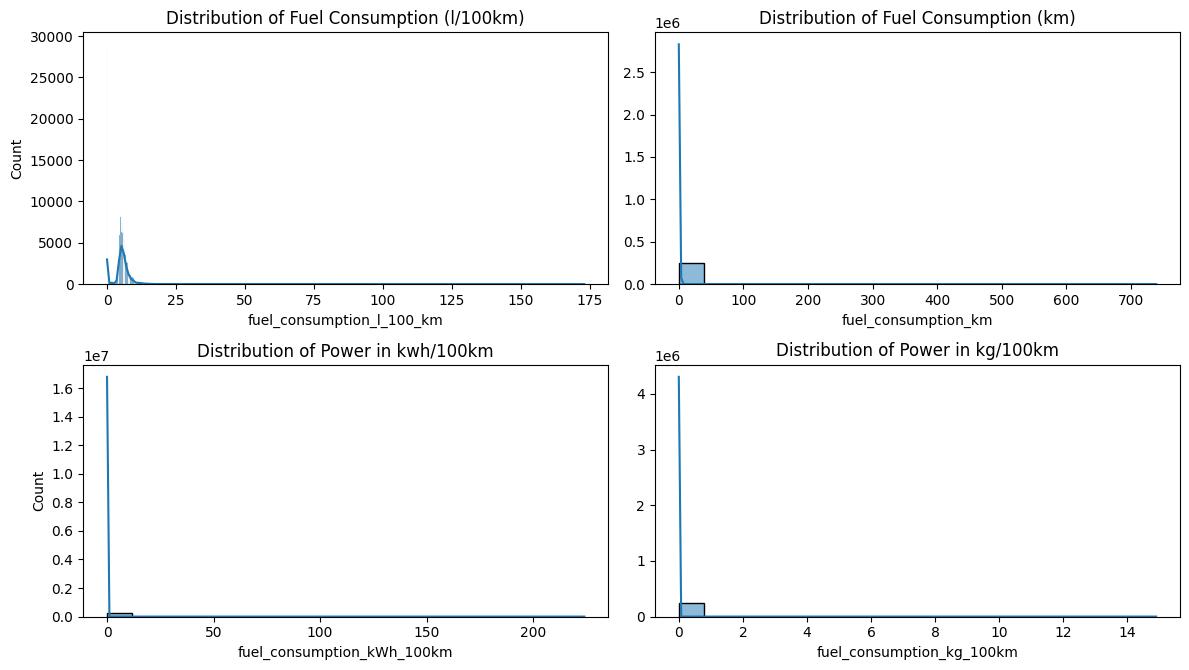

In [70]:
fig, axes = plt.subplots(2,2, figsize=(12,8))

sns.histplot(clean_df, x='fuel_consumption_l_100_km', kde=True, ax=axes[0,0])
axes[0,0].set_title('Distribution of Fuel Consumption (l/100km)')

sns.histplot(clean_df, x='fuel_consumption_km', kde=True, ax=axes[0,1])
axes[0,1].set_title('Distribution of Fuel Consumption (km)')
axes[0,1].set_ylabel('')

sns.histplot(clean_df, x='fuel_consumption_kWh_100km', kde=True, ax=axes[1,0])
axes[1,0].set_title('Distribution of Power in kwh/100km')

sns.histplot(clean_df, x='fuel_consumption_kg_100km', kde=True, ax=axes[1,1])
axes[1,1].set_title('Distribution of Power in kg/100km')
axes[1,1].set_ylabel('')

plt.tight_layout(rect=[0, 0.1, 1, 0.95])
plt.show()

Since the distributions are right skewed, we should transform using log transformation.

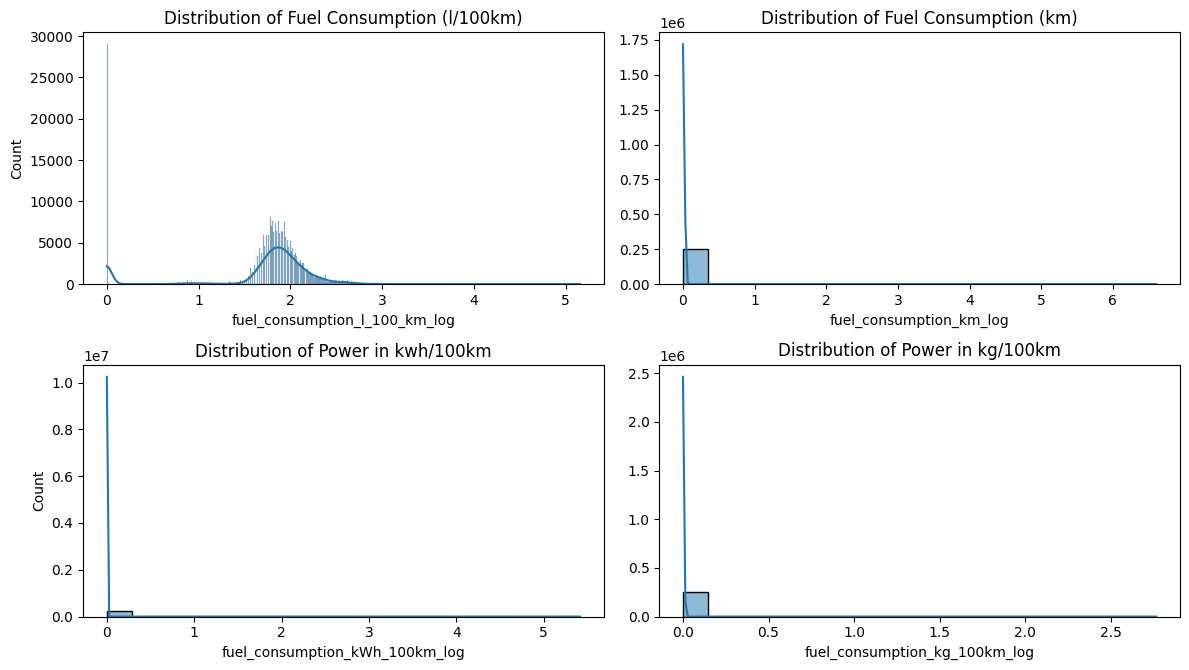

In [71]:
clean_df['fuel_consumption_l_100_km_log'] = np.log1p(clean_df['fuel_consumption_l_100_km'])
clean_df['fuel_consumption_km_log'] = np.log1p(clean_df['fuel_consumption_km'])
clean_df['fuel_consumption_kWh_100km_log'] = np.log1p(clean_df['fuel_consumption_kWh_100km'])
clean_df['fuel_consumption_kg_100km_log'] = np.log1p(clean_df['fuel_consumption_kg_100km'])

fig, axes = plt.subplots(2,2, figsize=(12,8))

sns.histplot(clean_df, x='fuel_consumption_l_100_km_log', kde=True, ax=axes[0,0])
axes[0,0].set_title('Distribution of Fuel Consumption (l/100km)')

sns.histplot(clean_df, x='fuel_consumption_km_log', kde=True, ax=axes[0,1])
axes[0,1].set_title('Distribution of Fuel Consumption (km)')
axes[0,1].set_ylabel('')

sns.histplot(clean_df, x='fuel_consumption_kWh_100km_log', kde=True, ax=axes[1,0])
axes[1,0].set_title('Distribution of Power in kwh/100km')

sns.histplot(clean_df, x='fuel_consumption_kg_100km_log', kde=True, ax=axes[1,1])
axes[1,1].set_title('Distribution of Power in kg/100km')
axes[1,1].set_ylabel('')

plt.tight_layout(rect=[0, 0.1, 1, 0.95])
plt.show()

### 2.2) Bivarient Analysis

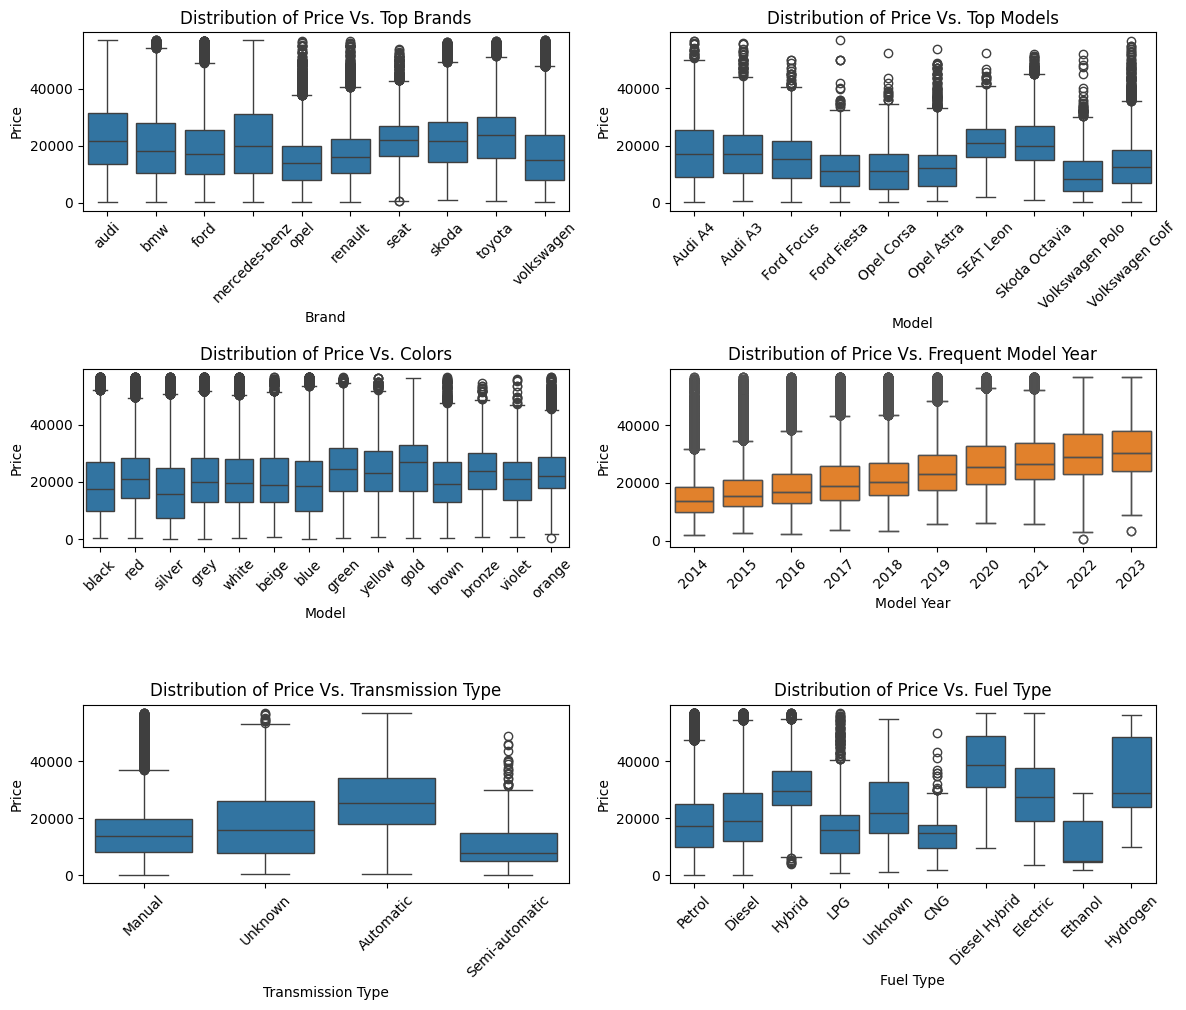

In [76]:
fig, axes = plt.subplots(3,2, figsize=(12,12))

top_brands = clean_df.brand.value_counts()[:10].index
df_filtered = clean_df[clean_df['brand'].isin(top_brands)]
sns.boxplot(df_filtered, x='brand', y='price_in_euro', ax=axes[0,0])
axes[0,0].tick_params(axis='x', rotation=45)
axes[0,0].set_xlabel('Brand')
axes[0,0].set_ylabel('Price')
axes[0,0].set_title('Distribution of Price Vs. Top Brands')

top_models = clean_df.model.value_counts()[:10].index
df_filtered = clean_df[clean_df['model'].isin(top_models)]
sns.boxplot(df_filtered, x='model', y='price_in_euro', ax=axes[0,1])
axes[0,1].tick_params(axis='x', rotation=45)
axes[0,1].set_xlabel('Model')
axes[0,1].set_ylabel('Price')
axes[0,1].set_title('Distribution of Price Vs. Top Models')

colors = clean_df.color.value_counts().index
df_filtered = clean_df[clean_df['color'].isin(colors)]
sns.boxplot(df_filtered, x='color', y='price_in_euro', ax=axes[1,0])
axes[1,0].tick_params(axis='x', rotation=45)
axes[1,0].set_xlabel('Model')
axes[1,0].set_ylabel('Price')
axes[1,0].set_title('Distribution of Price Vs. Colors')

years = clean_df.year.value_counts()[:10].index
df_filtered = clean_df[clean_df['year'].isin(years)]
sns.boxplot(df_filtered, x='year', y='price_in_euro', ax=axes[1,1])
axes[1,1].tick_params(axis='x', rotation=45)
axes[1,1].set_xlabel('Model Year')
axes[1,1].set_ylabel('Price')
axes[1,1].set_title('Distribution of Price Vs. Frequent Model Year')

years = clean_df.year.value_counts()[:10].index
df_filtered = clean_df[clean_df['year'].isin(years)]
sns.boxplot(df_filtered, x='year', y='price_in_euro', ax=axes[1,1])
axes[1,1].tick_params(axis='x', rotation=45)
axes[1,1].set_xlabel('Model Year')
axes[1,1].set_ylabel('Price')
axes[1,1].set_title('Distribution of Price Vs. Frequent Model Year')

transmission_type = clean_df.transmission_type.value_counts().index
df_filtered = clean_df[clean_df['transmission_type'].isin(transmission_type)]
sns.boxplot(df_filtered, x='transmission_type', y='price_in_euro', ax=axes[2,0])
axes[2,0].tick_params(axis='x', rotation=45)
axes[2,0].set_xlabel('Transmission Type')
axes[2,0].set_ylabel('Price')
axes[2,0].set_title('Distribution of Price Vs. Transmission Type')

fuel_type = clean_df.fuel_type.value_counts().index
df_filtered = clean_df[clean_df['fuel_type'].isin(fuel_type)]
sns.boxplot(df_filtered, x='fuel_type', y='price_in_euro', ax=axes[2,1])
axes[2,1].tick_params(axis='x', rotation=45)
axes[2,1].set_xlabel('Fuel Type')
axes[2,1].set_ylabel('Price')
axes[2,1].set_title('Distribution of Price Vs. Fuel Type')

plt.tight_layout(rect=[0, 0.1, 1, 0.95])
plt.show()

According to the multiple boxplots, there are many outliers in price column. I will fitler it out by quantile.

In [73]:
Q1 = clean_df['price_in_euro'].quantile(0.25)
Q3 = clean_df['price_in_euro'].quantile(0.75)

IQR = Q3 - Q1

upper_bound = Q3 + 1.5 * IQR

clean_df = clean_df[clean_df['price_in_euro'] < upper_bound]

### 2.3) Multivariate Analysis: How do the numerical features relate to each other?
Finally, I'll create a correlation heatmap to quickly see the linear relationships between all numerical variables. This is a powerful tool for identifying which features are most likely to influence the price.

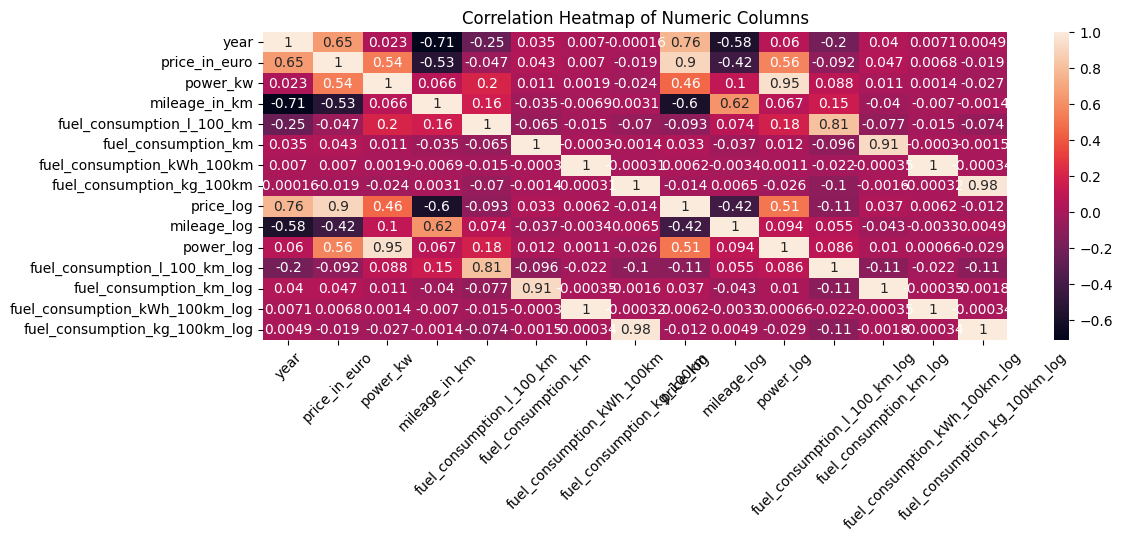

In [74]:
numeric_df = clean_df.select_dtypes('number')

fig, ax = plt.subplots(figsize=(12,4))
sns.heatmap(numeric_df.corr(), annot=True, ax=ax)
plt.tick_params(axis='x', rotation=45)
ax.set_title('Correlation Heatmap of Numeric Columns')
plt.show()

#### Key Insights from the Correlation Heatmap

The heatmap reveals the linear relationships between the numerical features after the data has been cleaned and filtered.

* **Power vs. Price (0.62):** There is a **strong positive correlation** between engine power (`power_kw`) and price. This is the most influential factor in the cleaned dataset, indicating that cars with more powerful engines are consistently valued higher.

* **Year vs. Price (0.28):** There is a **moderate positive correlation** between the car's production year (`year`) and its price. This confirms that newer cars tend to be more expensive.

* **Mileage vs. Price (-0.28):** There is a **weak negative correlation** between a car's mileage (`mileage_in_km`) and its price (`price_in_euro`). After cleaning and filtering the data, this relationship is not as strong as initially hypothesized. This suggests that for the more uniform group of cars in our cleaned dataset, other factors like power and brand may be more significant drivers of price than mileage alone.

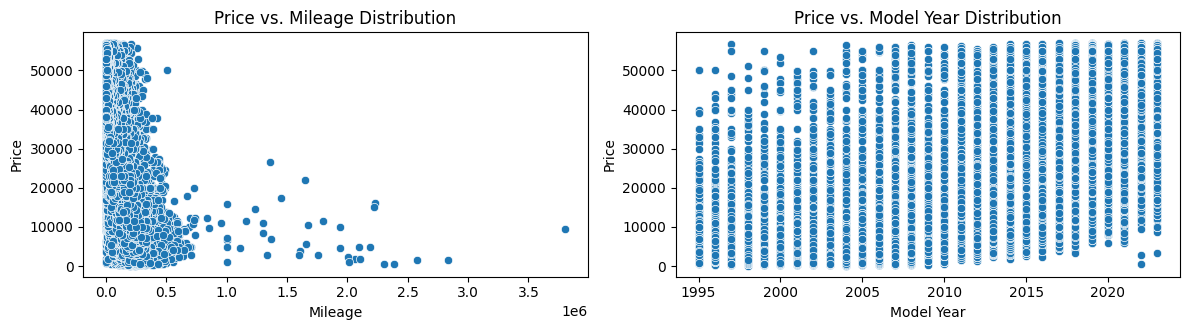

In [75]:
fig, axes = plt.subplots(1,2, figsize=(12, 4))

sns.scatterplot(data=clean_df, x='mileage_in_km', y='price_in_euro', ax=axes[0])
axes[0].set_title('Price vs. Mileage Distribution')
axes[0].set_xlabel('Mileage')
axes[0].set_ylabel('Price')

sns.scatterplot(data=clean_df, x='year', y='price_in_euro', ax=axes[1])
axes[1].set_title('Price vs. Model Year Distribution')
axes[1].set_xlabel('Model Year')
axes[1].set_ylabel('Price')

plt.tight_layout(rect=[0, 0.1, 1, 0.95])
plt.show()

## 3. Summary of Insights & Next Steps

This initial EDA has provided several key insights into the German used car market:
1.  **Price is driven by Age and Mileage:** The strongest factors influencing price are, unsurprisingly, the car's year of production and its mileage.
2.  **Brand Power:** Premium brands like Audi, Mercedes-Benz, and BMW consistently command higher median prices than mass-market brands.
3.  **Market Dominance:** German manufacturers are the most frequently listed, indicating strong domestic brand loyalty.

### Next Steps
Based on this analysis, a clear next step would be to perform **feature engineering** on the categorical variables (like `brand` and `model`) and then build a **machine learning model** to predict used car prices.